In [1]:
using PyCall
using JLD2
using FileIO
xr = pyimport("xarray");
using PyPlot
using ZfpCompression
ticker = pyimport("matplotlib.ticker");
using Elefridge
using StatsBase, Statistics
using NetCDF

In [2]:
using TranscodingStreams,CodecZstd

ZstdCompressorL3 = ZstdCompressor(level=3)
TranscodingStreams.initialize(ZstdCompressorL3)

ZstdCompressorL10 = ZstdCompressor(level=10)
TranscodingStreams.initialize(ZstdCompressorL10)

ZstdCompressorL22 = ZstdCompressor(level=22)
TranscodingStreams.initialize(ZstdCompressorL22)

In [6]:
ncfile = NetCDF.open("/data1/fullvertical/ensemble.t.member1.steps1-10.ll.nc")
temp = ncfile.vars["t"][:,:,:,:];

In [7]:
size(temp)

(1800, 901, 91, 10)

## 1. ZFP: Compress only horizontal 2D

In [8]:
cfs_zfp_2d_hori_all = fill(0.0,prod(size(temp)[3:4]))
ori_size = sizeof(temp[:,:,1,1])*2   # relative to Float64

j = 1
for it in 1:size(temp)[4]
    for iv in 1:size(temp)[3]
        cfs_zfp_2d_hori_all[j] = ori_size/sizeof(zfp_compress(temp[:,:,iv,it],precision=11))
        j += 1
    end
end

## 2. ZFP: Compress spatial 3D

In [9]:
cfs_zfp_3d_space_all = fill(0.0,size(temp)[4])
ori_size = sizeof(temp[:,:,:,1])*2   # relative to Float64

j = 1
for it in 1:size(temp)[4]
    cfs_zfp_3d_space_all[j] = ori_size/sizeof(zfp_compress(temp[:,:,:,it],precision=13))
    j += 1
end

## 3. ZFP: Compress horizontal + time 3D

In [10]:
cfs_zfp_3d_horitime_all = fill(0.0,size(temp)[3])
ori_size = sizeof(temp[:,:,1,:])*2   # relative to Float64

j = 1
for iv in 1:size(temp)[3]
    cfs_zfp_3d_horitime_all[j] = ori_size/sizeof(zfp_compress(temp[:,:,iv,:],precision=13))
    j += 1
end

## 4. ZFP: Compress in space and time

In [11]:
nens = 5 #2
cfs_zfp_4d_spacetime = fill(0.0,nens)    # calculate for nens ensemble members
ori_size = sizeof(temp)*2   # relative to Float64

# for ie in 1:nens
#     ir = rand(1:50)
#     print(ie,ir)
#     path = ir > 25 ? "/data2" : "/data1"
#     ncfile = NetCDF.open(path*"/ens/ensemble.t.member$ir.steps1-90.ll.nc")
#     temp[:] = ncfile.vars["t"][:,:,:,:];
#     cfs_zfp_4d_spacetime[ie] = ori_size/sizeof(zfp_compress(temp,precision=14))
# end

# # reload member 1
# ncfile = NetCDF.open("/data1/ens/ensemble.t.member1.steps1-90.ll.nc")
# temp[:] = ncfile.vars["t"][:,:,:,:];

## 5. ZSTD COMPRESS ALONG VARIOUS DIMENSIONS

In [14]:
n_montecarlo = 1

# LONGITUDE
cfs_zstd_longitude = fill(0.0,n_montecarlo)

for i in 1:n_montecarlo
    print(i)
    tstart = 1+(i-1)*5
    tend = tstart+9
    Xr = round(temp[:,:,:,tstart:tend],7)
    # no permutation of dimensions
    Xr8 = copy(reinterpret(UInt8,vec(Xr)))
    cfs_zstd_longitude[i] = 2*sizeof(Xr)/sizeof(transcode(ZstdCompressorL10,Xr8))
end

1

In [15]:
# LATITUDE
cfs_zstd_latitude = fill(0.0,n_montecarlo)

for i in 1:n_montecarlo
    print(i)
    tstart = 1+(i-1)*5
    tend = tstart+9
    Xr = round(temp[:,:,:,tstart:tend],7)
    Xr = permutedims(Xr,[2,1,3,4])    # latitude first, then longitude etc
    Xr8 = copy(reinterpret(UInt8,vec(Xr)))
    cfs_zstd_latitude[i] = 2*sizeof(Xr)/sizeof(transcode(ZstdCompressorL10,Xr8))
end

1

In [17]:
# VERTICAL
cfs_zstd_vertical = fill(0.0,n_montecarlo)

for i in 1:n_montecarlo
    print(i)
    Xr = round(temp[:,:,:,i],7)  # use dataset with all 137 vertical levels, but subsample latitudes
    Xr = permutedims(Xr,[3,1,2])    # vertical first, then longitude etc
    Xr8 = copy(reinterpret(UInt8,vec(Xr)))
    cfs_zstd_vertical[i] = 2*sizeof(Xr)/sizeof(transcode(ZstdCompressorL10,Xr8))
end

1

In [18]:
# TIME
cfs_zstd_time = fill(0.0,n_montecarlo)

for i in 1:n_montecarlo
    print(i)
    Xr = round(temp[:,i:5:end,:,:],7)
    Xr = permutedims(Xr,[4,1,2,3])    # time first, then longitude etc
    Xr8 = copy(reinterpret(UInt8,vec(Xr)))
    cfs_zstd_time[i] = 2*sizeof(Xr)/sizeof(transcode(ZstdCompressorL10,Xr8))
end

1

In [19]:
# ENSEMBLE
Xzstd1,Xzfp1 = load("/home/milan/analysis/ensemble_compression_1-90.jld2","Xzstd","Xzfp")
Xzstd2,Xzfp2 = load("/home/milan/analysis/ensemble_compression_90-144.jld2","Xzstd","Xzfp")
Xzstd3,Xzfp3 = load("/home/milan/analysis/ensemble_compression_150-360.jld2","Xzstd","Xzfp")
cfs_zstd_ens = vcat(Xzstd1,Xzstd2,Xzstd3)
cfs_zfp_ens = vcat(Xzfp1,Xzfp2,Xzfp3);

## Calculate means and uncertainties

In [20]:
cfs_basic = [1,8/3,4]   # compression factors for uncompressed, 24-bit and 16-bit
labels_basic = ["No compression, any dimensions","LinQuant24, any dimensions","LogQuant16, any dimensions"]

# ZSTANDARD
cfs_zstd = [1/mean(1.0 ./ cfs_zstd_longitude),    # geometric mean
            1/mean(1.0 ./ cfs_zstd_latitude),
            1/mean(1.0 ./ cfs_zstd_vertical),
            1/mean(1.0 ./ cfs_zstd_time),
            1/mean(1.0 ./ cfs_zstd_ens)]
cfs_zstd5 = [1/minimum(1.0 ./ cfs_zstd_longitude),    # geometric
            1/minimum(1.0 ./ cfs_zstd_latitude),
            1/minimum(1.0 ./ cfs_zstd_vertical),
            1/minimum(1.0 ./ cfs_zstd_time),
            1/minimum(1.0 ./ cfs_zstd_ens)]
cfs_zstd95 = [1/maximum(1.0 ./ cfs_zstd_longitude),    # geometric
            1/maximum(1.0 ./ cfs_zstd_latitude),
            1/maximum(1.0 ./ cfs_zstd_vertical),
            1/maximum(1.0 ./ cfs_zstd_time),
            1/maximum(1.0 ./ cfs_zstd_ens)]

labels_zstd = ["Longitude","Latitude",
                "Vertical","Time","Ensemble"]

# ZFP COMPRESSION
cfs_zfp = [1/mean(1.0 ./ cfs_zfp_2d_hori_all),    # geometric mean
           1/mean(1.0 ./ cfs_zfp_3d_space_all),
           1/mean(1.0 ./ cfs_zfp_3d_horitime_all),
           1/mean(1.0 ./ cfs_zfp_4d_spacetime),
           1/mean(1.0 ./ cfs_zfp_ens)]
cfs_zfp5 = [1/percentile(1.0 ./ cfs_zfp_2d_hori_all,5),    # geometric
            1/percentile(1.0 ./ cfs_zfp_3d_space_all,5),
            1/percentile(1.0 ./ cfs_zfp_3d_horitime_all,5),
            1/percentile(1.0 ./ cfs_zfp_4d_spacetime,5),
            1/percentile(1.0 ./ cfs_zfp_ens,5),]
cfs_zfp95 = [1/percentile(1.0 ./ cfs_zfp_2d_hori_all,95),    # geometric
            1/percentile(1.0 ./ cfs_zfp_3d_space_all,95),
            1/percentile(1.0 ./ cfs_zfp_3d_horitime_all,95),
            1/percentile(1.0 ./ cfs_zfp_4d_spacetime,95),
            1/percentile(1.0 ./ cfs_zfp_ens,95),]
labels_zfp = ["Horizontal 2D","Horizontal+Vertical 3D",
                "Horizontal+Time 3D","Space+Time 4D","Space+Ensemble 4D"]

5-element Array{String,1}:
 "Horizontal 2D"
 "Horizontal+Vertical 3D"
 "Horizontal+Time 3D"
 "Space+Time 4D"
 "Space+Ensemble 4D"

## PLOTTING

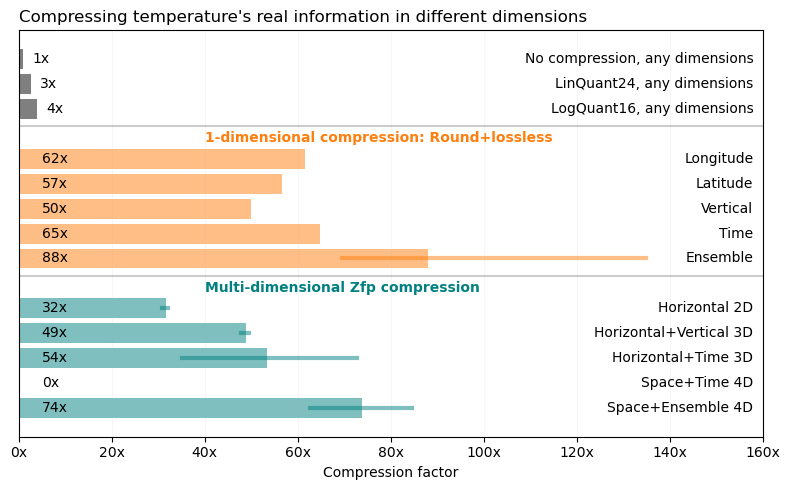

In [21]:
# PLOT
fig,ax1 = subplots(1,1,figsize=(8,5),sharex=true)

alfa = 0.5
xmax = 160

i = 1
for (cf,label) in zip(cfs_basic,labels_basic)
    ax1.barh(i,cf,color="k",alpha=alfa)
    ax1.text(xmax-2,i,label,ha="right",va="center")
    ax1.text(cf+2,i,string(round(Int,cf))*"x",ha="left",va="center")
    i += 1
end

ax1.axhline(i-.3,color="k",alpha=.2)
ax1.text(40,i-.1,"1-dimensional compression: Round+lossless",va="top",color="C1",fontweight="bold")
i += 1

for (cf,cf5,cf95,label) in zip(cfs_zstd,cfs_zstd5,cfs_zstd95,labels_zstd)
    ax1.barh(i,cf,color="C1",alpha=alfa)
    ax1.plot([cf5,cf95],[i,i],"C1",lw=3,alpha=alfa)
    ax1.text(xmax-2,i,label,ha="right",va="center")
    ax1.text(5,i,string(round(Int,cf))*"x",ha="left",va="center")
    i += 1
end

ax1.axhline(i-.3,color="k",alpha=.2)
ax1.text(40,i-.1,"Multi-dimensional Zfp compression",va="top",color="teal",fontweight="bold")
i += 1

for (cf,cf5,cf95,label) in zip(cfs_zfp,cfs_zfp5,cfs_zfp95,labels_zfp)
    ax1.barh(i,cf,color="teal",alpha=alfa)
    ax1.plot([cf5,cf95],[i,i],color="teal",lw=3,alpha=alfa)
    ax1.text(xmax-2,i,label,ha="right",va="center")
    ax1.text(5,i,string(round(Int,cf))*"x",ha="left",va="center")
    i += 1
end

ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter("%dx"))
ax1.invert_yaxis()
ax1.set_yticks([])
ax1.set_xlim(0,xmax)
ax1.set_xlabel("Compression factor")
ax1.set_title("Compressing temperature's real information in different dimensions",loc="left")
ax1.grid(alpha=0.1)
tight_layout()
# savefig("../plots/cfs_dimensions.png")